In [1]:
from PIL import Image
from rl_benchmarks.models import iBOTViT
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator
import pathlib
from tqdm import tqdm
from PIL import Image
import numpy as np
Image.MAX_IMAGE_PIXELS = None
from torchvision import transforms
import torch
from torch.utils.data import Dataset
import os
from multiprocessing import Pool
import umap
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from rl_benchmarks.utils.linear_evaluation import get_binary_class_metrics, get_bootstrapped_metrics, dict_to_dataframe
import umap.plot

/home/yuxin/miniconda3/envs/histosslscaling/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
weights_path = '/home/yuxin/Downloads/ibot_vit_base_pancan.pth'
ibot_base_pancancer = iBOTViT(architecture="vit_base_pancan", encoder="student", weights_path=weights_path).to(device)

2023-11-27 16:47:08.010 | INFO     | rl_benchmarks.models.feature_extractors.ibot_vit:__init__:78 - Pretrained weights found at /home/yuxin/Downloads/ibot_vit_base_pancan.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['masked_embed', 'head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v', 'head.last_layer2.weight_g', 'head.last_layer2.weight_v'])


In [3]:
# slide_path = '/mnt/hd0/original_datasets/JT_Breast/SHSU/svs/00003-2018-2.svs'
# slide = open_slide(slide_path)
# dzg = DeepZoomGenerator(slide, tile_size=224, overlap=0)

In [4]:
# tile = dzg.get_tile(level=15, address=(50, 50))
# tile

In [5]:
patch_size = 224
data_root = pathlib.Path('/mnt/hd0/original_datasets/JT_Breast/SUQH/40xTiles')
split_root = pathlib.Path('/mnt/hd0/project_large_files/bca_grading/suqh/split_data')
phases = ['train', 'val', 'test']
save_root = split_root / f'center_crop_features_10x_{patch_size}'
save_root.mkdir(exist_ok=True)
data_trans = transforms.Compose([
                                transforms.CenterCrop(patch_size*4),
                                transforms.Resize(patch_size),
                                ibot_base_pancancer.transform,
                                ])

In [6]:
# for phase in phases:
#     phase_root = split_root / phase
#     tile_paths = list(phase_root.glob('**/*.png'))
#     for path in tqdm(tile_paths, desc=f'Processing {phase}'):
#         im = Image.open(path)
#         tensor = data_trans(im)
#         batch = tensor.unsqueeze(0)
#         batch = batch.to(device)
#         features = ibot_base_pancancer(batch).detach().cpu().numpy()
#         save_path = save_root / phase / path.parent.name / f'{path.stem}.npy' 
#         save_path.parent.mkdir(exist_ok=True, parents=True)
#         np.save(save_path, features)
        


In [7]:
# class MyDataSet(Dataset):
#     """自定义数据集"""

#     def __init__(self, data_root:str, split_file:str,transform):
#         images_path = []
#         images_class = []
#         with open(split_file, 'r') as f:
#             lines = f.readlines()
#             for line in lines:
#                 label = line[-2:-1]
#                 img_name = line[:-3]
#                 img_path = os.path.join(data_root, img_name)
#                 images_path.append(img_path)
#                 images_class.append(int(label))
 
#         self.images_path = images_path
#         self.images_class = images_class
#         self.transform = transform

#     def __len__(self):
#         return len(self.images_path)

#     def __getitem__(self, item):
#         img = Image.open(self.images_path[item])
#         # RGB为彩色图片，L为灰度图片
#         if img.mode != 'RGB':
#             raise ValueError("image: {} isn't RGB mode.".format(self.images_path[item]))
#         label = self.images_class[item]
#         img = self.transform(img)

#         return img, label, self.images_path[item]

# def post_process(feature, label, path, phase):
#     path = pathlib.Path(path)
#     savepath = save_root / phase / label / f'{path.stem}.npy'
#     savepath.parent.mkdir(exist_ok=True, parents=True)
#     np.save(savepath, feature)

# bs = 16
# n_worker = 16
# for phase in phases:
#     split_file = split_root / f'{phase}.txt'
#     dataset = MyDataSet(data_root=data_root,split_file=split_file, transform=data_trans)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=False, num_workers=n_worker)

#     for batch in tqdm(dataloader, desc=f'Processing {phase}'):
#         imgs, labels, paths = batch
#         imgs = imgs.to(device)
#         features = ibot_base_pancancer(imgs).detach().cpu().numpy()
#         labels = labels.numpy()

#         # for i, path in enumerate(paths):
#         #     path = pathlib.Path(path)
#         #     save_path = save_root / phase / path.parent.name / f'{path.stem}.npy' 
#         #     save_path.parent.mkdir(exist_ok=True, parents=True)
#         #     np.save(save_path, features[i]) 
        
#         with Pool(n_worker) as p:
#             p.starmap(post_process, zip(features, labels, paths, [phase]*len(features)))


In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(confusion_matrix, labels):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.title('Confusion Matrix')
    plt.show()

In [9]:
def get_metrics(labels, scores, class_names, phase='test'):
    n_resamples = 1000
    confidence_level = 0.95

    binary_metrics = {phase:get_binary_class_metrics(labels, scores)}
    bootstrapped_metrics = {phase: get_bootstrapped_metrics(
        labels, scores, n_resamples=n_resamples, confidence_level=confidence_level
    )}

    results_dict = {
        "binary": binary_metrics,
        "bootstrap": bootstrapped_metrics,
    }
    
    results = dict_to_dataframe(
        results_dict, metrics=["auc", "acc", "f1"], class_names=class_names
    )
    return results


In [10]:
def path2tglabel(path):
    _type = path.stem.split('-')[-2]
    _grade = int(path.stem.split('-')[-1])
    if _type == 'dcis':
        if _grade == 1:
            return 0
        elif _grade == 2:
            return 1
        elif _grade == 3:
            return 2
    else:
        if _grade == 1:
            return 3
        elif _grade == 2:
            return 4
        elif _grade == 3:
            return 5

In [11]:
features = {}
labels = {
    'grade': {},
    'type': {},
    'type_grade': {},
}
for phase in phases:
    feature_root = save_root / phase
    feature_paths = list(feature_root.glob('**/*.npy'))
    _features = [np.load(path) for path in feature_paths]

    g_labels = [int(path.stem.split('-')[-1])-1 for path in feature_paths]
    t_labels = [0 if path.stem.split('-')[-2]=='dcis' else 1 for path in feature_paths]
    tg_labels = [path2tglabel(path) for path in feature_paths]

    features[phase] = _features
    labels['grade'][phase] = g_labels
    labels['type'][phase] = t_labels
    labels['type_grade'][phase] = tg_labels   

# Task 1: Grade 1 vs Grade 2 vs Grade 3

<Axes: >

<Figure size 1000x1000 with 0 Axes>

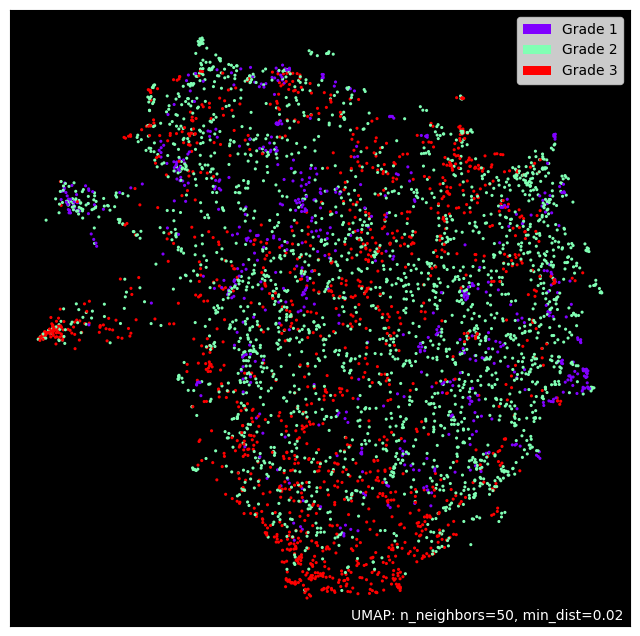

In [79]:
class_names = ['Grade 1', 'Grade 2', 'Grade 3']
mapper = umap.UMAP(n_neighbors=50, min_dist=0.02).fit(features['train'] + features['val'])
fig = plt.figure(figsize=(10, 10), dpi=100)
umap.plot.points(mapper, 
                 labels=np.array(class_names)[np.array(labels['grade']['train'] + labels['grade']['val'])], 
                 theme='fire')

In [34]:
model1 = sklearn.linear_model.SGDClassifier(
                loss="log_loss",
                penalty="l2",
                learning_rate="adaptive",
                eta0=1e-4,
                n_jobs=8,
                early_stopping=False,
                random_state=2023,
            ).fit(features['train']+features['val'], labels['grade']['train']+labels['grade']['val'])

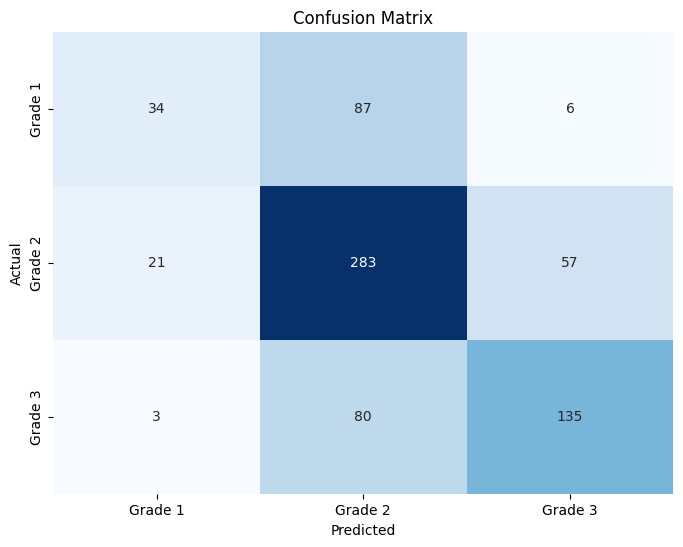

,0
portion,test
Grade 1_auc,0.804918
Grade 1_acc,0.834278
Grade 1_f1,0.367568
Grade 2_auc,0.684243
Grade 2_acc,0.652975
Grade 2_f1,0.697904
Grade 3_auc,0.8479
Grade 3_acc,0.793201
Grade 3_f1,0.649038


In [41]:
model = model1
test_scores = model.predict_proba(features['test'])
test_preds = model.predict(features['test'])
plot_confusion_matrix(confusion_matrix(labels['grade']['test'], test_preds), class_names)
get_metrics(labels['grade']['test'], test_scores, class_names).T

# Task 2: Grade 1&3 vs Grade 2

In [42]:
def cvlabels_13_vs_2(label):
    if label == 0:
        return 0
    elif label == 2:
        return 0
    else:
        return 1

<Axes: >

<Figure size 1000x1000 with 0 Axes>

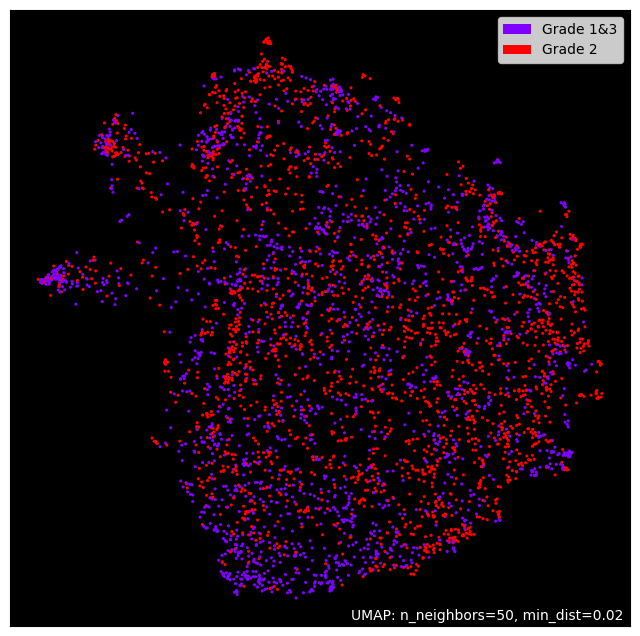

In [78]:
class_names = ['Grade 1&3', 'Grade 2']
mapper = umap.UMAP(n_neighbors=50, min_dist=0.02).fit(features['train'] + features['val'])
fig = plt.figure(figsize=(10, 10), dpi=100)
umap.plot.points(mapper, 
                 labels=np.array(class_names)[np.array(list(map(cvlabels_13_vs_2, labels['grade']['train'] + labels['grade']['val'])))], 
                 theme='fire')

In [45]:
model2 = sklearn.linear_model.SGDClassifier(
                loss="log_loss",
                penalty="l2",
                learning_rate="adaptive",
                eta0=1e-4,
                n_jobs=8,
                early_stopping=False,
                random_state=2023,
            ).fit(features['train']+features['val'], list(map(cvlabels_13_vs_2, labels['grade']['train']+labels['grade']['val'])))

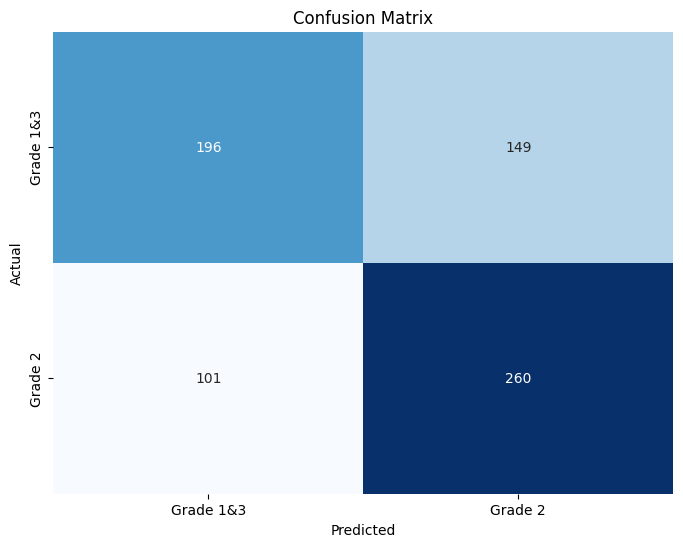

,0
portion,test
Grade 1&3_auc,0.673066
Grade 1&3_acc,0.645892
Grade 1&3_f1,0.610592
Grade 2_auc,0.673066
Grade 2_acc,0.645892
Grade 2_f1,0.675325
auc,0.673066
acc,0.645892
f1,0.675325


In [46]:
model = model2
test_scores = model.predict_proba(features['test'])
test_preds = model.predict(features['test'])
plot_confusion_matrix(confusion_matrix(list(map(cvlabels_13_vs_2, labels['grade']['test'])), test_preds), class_names)
get_metrics(list(map(cvlabels_13_vs_2, labels['grade']['test'])), test_scores, class_names).T

# Task 3: Grade 1&2 vs 3

In [47]:
def cvlabels_12_vs_3(label):
    if label == 0:
        return 0
    elif label == 1:
        return 0
    else:
        return 1

<Axes: >

<Figure size 1000x1000 with 0 Axes>

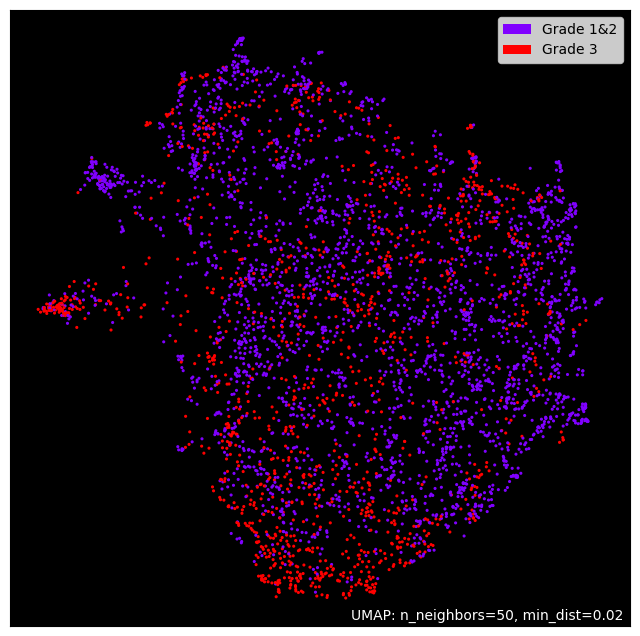

In [77]:
class_names = ['Grade 1&2', 'Grade 3']
mapper = umap.UMAP(n_neighbors=50, min_dist=0.02).fit(features['train'] + features['val'])
fig = plt.figure(figsize=(10, 10), dpi=100)
umap.plot.points(mapper, 
                 labels=np.array(class_names)[np.array(list(map(cvlabels_12_vs_3, labels['grade']['train'] + labels['grade']['val'])))], 
                 theme='fire')

In [49]:
model3 = sklearn.linear_model.SGDClassifier(
                loss="log_loss",
                penalty="l2",
                learning_rate="adaptive",
                eta0=1e-4,
                n_jobs=8,
                early_stopping=False,
                random_state=2023,
            ).fit(features['train']+features['val'], list(map(cvlabels_12_vs_3, labels['grade']['train']+labels['grade']['val'])))

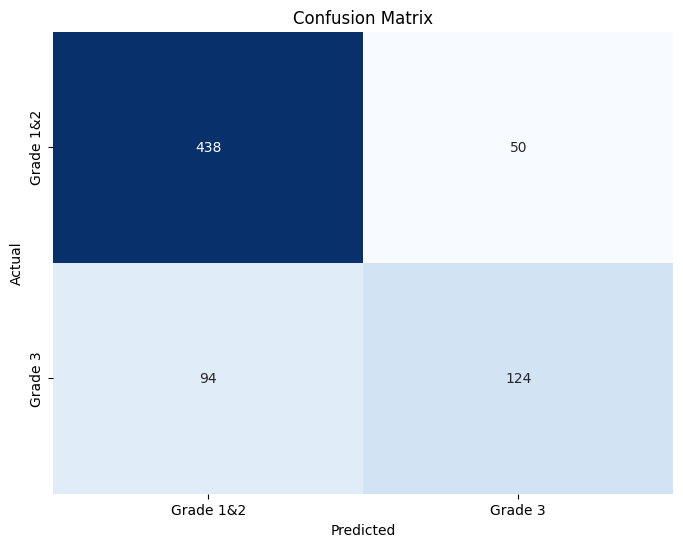

,0
portion,test
Grade 1&2_auc,0.844826
Grade 1&2_acc,0.796034
Grade 1&2_f1,0.858824
Grade 3_auc,0.844826
Grade 3_acc,0.796034
Grade 3_f1,0.632653
auc,0.844826
acc,0.796034
f1,0.632653


In [52]:
model = model3
test_scores = model.predict_proba(features['test'])
test_preds = model.predict(features['test'])
plot_confusion_matrix(confusion_matrix(list(map(cvlabels_12_vs_3, labels['grade']['test'])), test_preds), class_names)
get_metrics(list(map(cvlabels_12_vs_3, labels['grade']['test'])), test_scores, class_names).T

# Task 4: Grade 2&3 vs Grade 1

In [53]:
def cvlabels_23_vs_1(label):
    if label == 0:
        return 1
    else:
        return 0

<Axes: >

<Figure size 1000x1000 with 0 Axes>

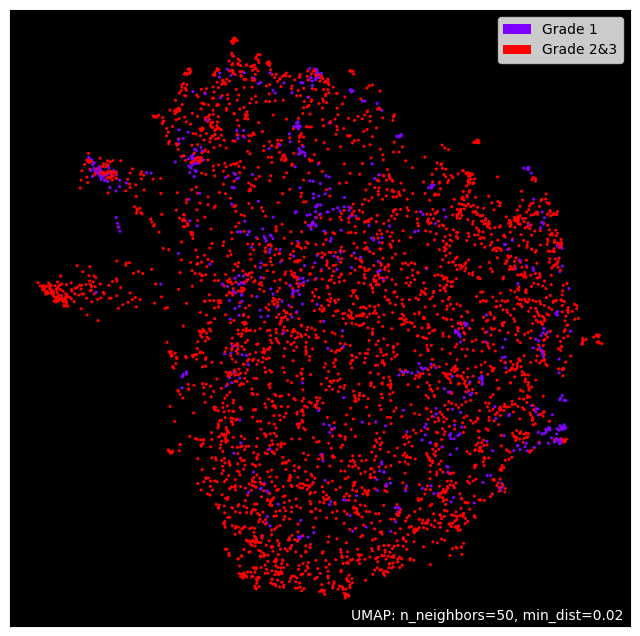

In [75]:
class_names = ['Grade 2&3', 'Grade 1']
mapper = umap.UMAP(n_neighbors=50, min_dist=0.02).fit(features['train'] + features['val'])
fig = plt.figure(figsize=(10, 10), dpi=100)
umap.plot.points(mapper, 
                 labels=np.array(class_names)[np.array(list(map(cvlabels_23_vs_1, labels['grade']['train'] + labels['grade']['val'])))], 
                 theme='fire')

In [55]:
model4 = sklearn.linear_model.SGDClassifier(
                loss="log_loss",
                penalty="l2",
                learning_rate="adaptive",
                eta0=1e-4,
                n_jobs=8,
                early_stopping=False,
                random_state=2023,
            ).fit(features['train']+features['val'], list(map(cvlabels_23_vs_1, labels['grade']['train']+labels['grade']['val'])))

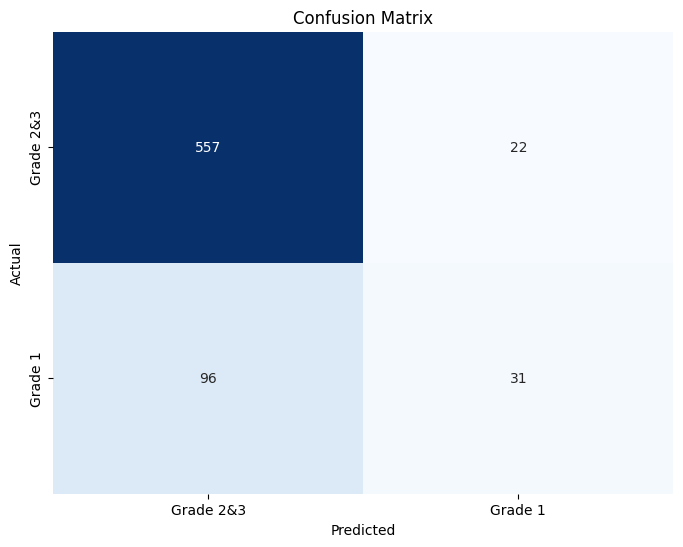

,0
portion,test
Grade 2&3_auc,0.806509
Grade 2&3_acc,0.832861
Grade 2&3_f1,0.904221
Grade 1_auc,0.806509
Grade 1_acc,0.832861
Grade 1_f1,0.344444
auc,0.806509
acc,0.832861
f1,0.344444


In [76]:
model = model4
test_scores = model.predict_proba(features['test'])
test_preds = model.predict(features['test'])
plot_confusion_matrix(confusion_matrix(list(map(cvlabels_23_vs_1,labels['grade']['test'])), test_preds), class_names)
get_metrics(list(map(cvlabels_23_vs_1,labels['grade']['test'])), test_scores, class_names).T

# Task 5: Only Grade 1 vs Grade 3

In [57]:
wo2_features = {}
wo2_labels = {
    'grade': {},
}

for phase in phases:
    for i in range(len(labels['grade'][phase])):
        label = labels['grade'][phase][i]
        if label != 1:
            wo2_features.setdefault(phase, []).append(features[phase][i])
            if label==0:
                wo2_labels['grade'].setdefault(phase, []).append(0)
            else:
                wo2_labels['grade'].setdefault(phase, []).append(1)

<Axes: >

<Figure size 1000x1000 with 0 Axes>

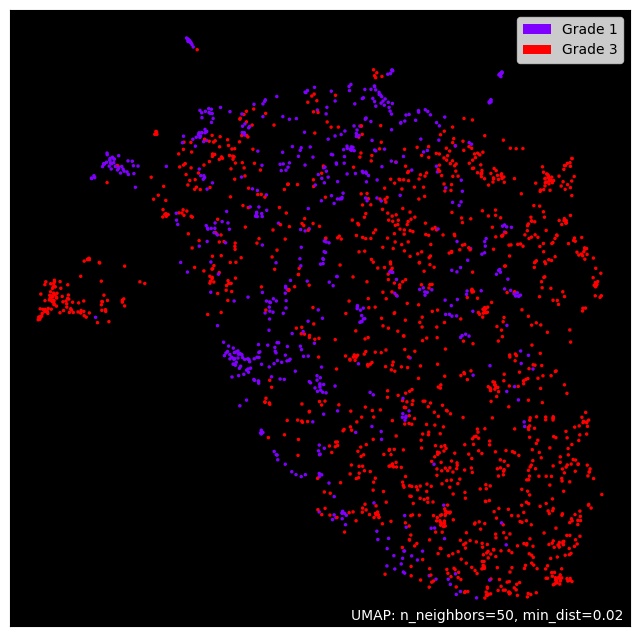

In [73]:
class_names = ['Grade 1', 'Grade 3']
mapper = umap.UMAP(n_neighbors=50, min_dist=0.02).fit(wo2_features['train'] + wo2_features['val'])
fig = plt.figure(figsize=(10, 10), dpi=100)
umap.plot.points(mapper, 
                 labels=np.array(class_names)[np.array(wo2_labels['grade']['train'] + wo2_labels['grade']['val'])], 
                 theme='fire')

In [63]:
model5 = sklearn.linear_model.SGDClassifier(
                loss="log_loss",
                penalty="l2",
                learning_rate="adaptive",
                eta0=1e-4,
                n_jobs=8,
                early_stopping=False,
                random_state=2023,
            ).fit(wo2_features['train']+wo2_features['val'], wo2_labels['grade']['train']+wo2_labels['grade']['val'])

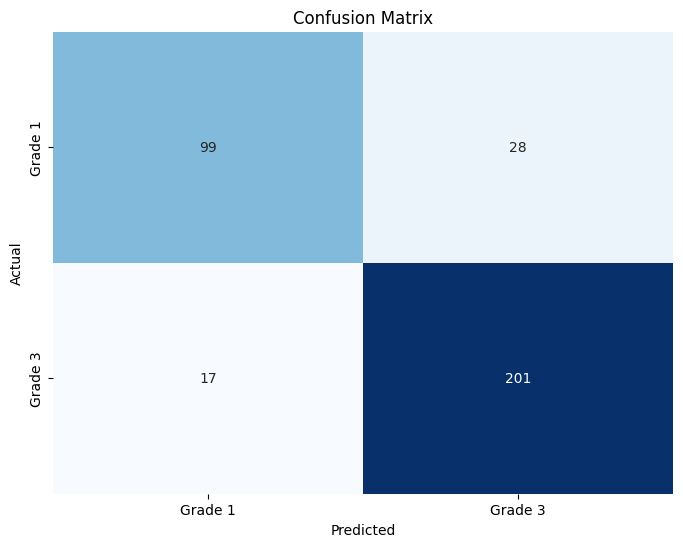

,0
portion,test
Grade 1_auc,0.931554
Grade 1_acc,0.869565
Grade 1_f1,0.814815
Grade 3_auc,0.931554
Grade 3_acc,0.869565
Grade 3_f1,0.899329
auc,0.931554
acc,0.869565
f1,0.899329


In [64]:
model = model5
test_scores = model.predict_proba(wo2_features['test'])
test_preds = model.predict(wo2_features['test'])
plot_confusion_matrix(confusion_matrix(wo2_labels['grade']['test'], test_preds), class_names)
get_metrics(wo2_labels['grade']['test'], test_scores, class_names).T

# Task 6: Type nonIBC vs IBC

<Axes: >

<Figure size 1000x1000 with 0 Axes>

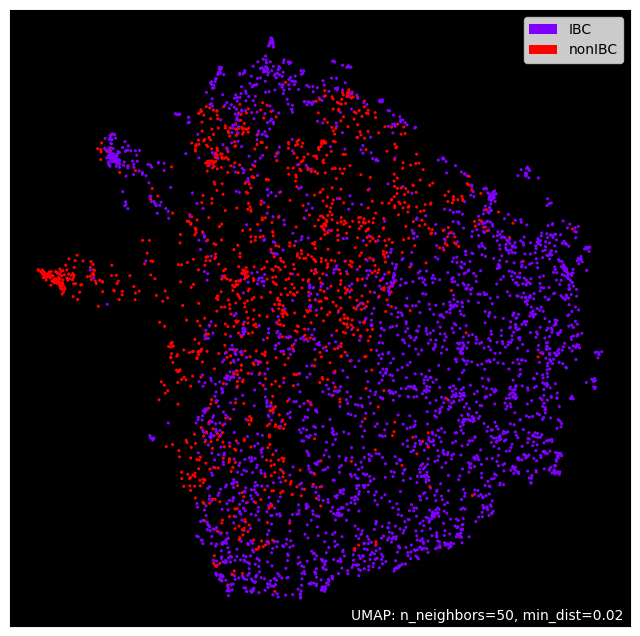

In [72]:
class_names = ['nonIBC', 'IBC']
mapper = umap.UMAP(n_neighbors=50, min_dist=0.02).fit(features['train'] + features['val'])
fig = plt.figure(figsize=(10, 10), dpi=100)
umap.plot.points(mapper, 
                 labels=np.array(class_names)[np.array(labels['type']['train'] + labels['type']['val'])],
                 theme='fire')

In [66]:
model6 = sklearn.linear_model.SGDClassifier(
                loss="log_loss",
                penalty="l2",
                learning_rate="adaptive",
                eta0=1e-4,
                n_jobs=8,
                early_stopping=False,
                random_state=2023,
            ).fit(features['train']+features['val'], labels['type']['train']+labels['type']['val'])

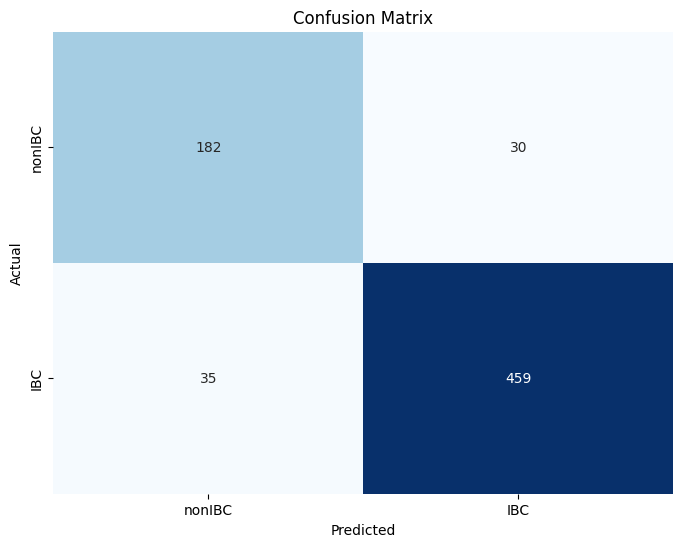

,0
portion,test
nonIBC_auc,0.970753
nonIBC_acc,0.907932
nonIBC_f1,0.848485
IBC_auc,0.970753
IBC_acc,0.907932
IBC_f1,0.933876
auc,0.970753
acc,0.907932
f1,0.933876


In [67]:
model = model6
test_scores = model.predict_proba(features['test'])
test_preds = model.predict(features['test'])
plot_confusion_matrix(confusion_matrix(labels['type']['test'], test_preds), class_names)
get_metrics(labels['type']['test'], test_scores, class_names).T

# Task 7: nonIBC-1 vs nonIBC-2 vs nonIBC-3 vs IBC-1 vs IBC-2 vs IBC-3

<Axes: >

<Figure size 1000x1000 with 0 Axes>

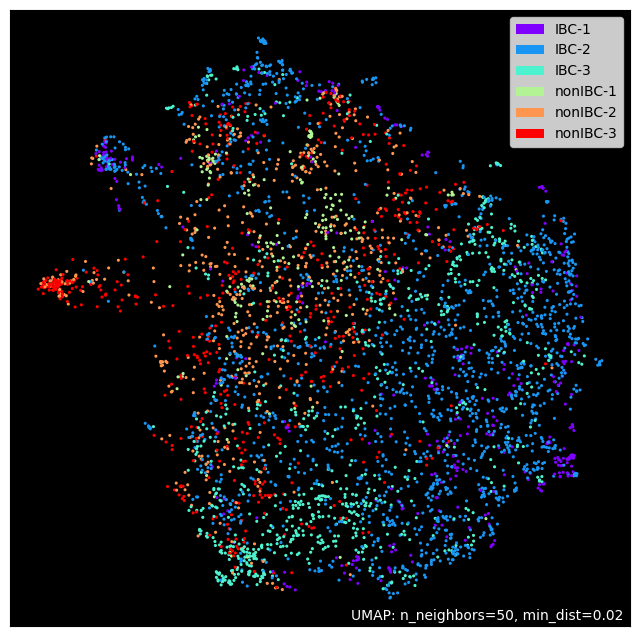

In [71]:
class_names = ['nonIBC-1', 'nonIBC-2', 'nonIBC-3', 'IBC-1', 'IBC-2', 'IBC-3']
mapper = umap.UMAP(n_neighbors=50, min_dist=0.02).fit(features['train'] + features['val'])
fig = plt.figure(figsize=(10, 10), dpi=100)
umap.plot.points(mapper, 
                 labels=np.array(class_names)[np.array(labels['type_grade']['train'] + labels['type_grade']['val'])], 
                 theme='fire')

In [69]:
model7 = sklearn.linear_model.SGDClassifier(
                loss="log_loss",
                penalty="l2",
                learning_rate="adaptive",
                eta0=1e-4,
                n_jobs=8,
                early_stopping=False,
                random_state=2023,
            ).fit(features['train']+features['val'], labels['type_grade']['train']+labels['type_grade']['val'])

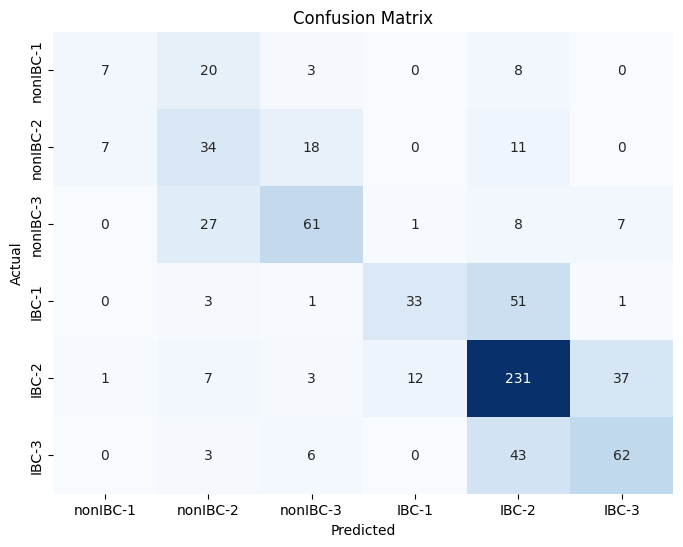

,0
portion,test
nonIBC-1_auc,0.89584
nonIBC-1_acc,0.944759
nonIBC-1_f1,0.264151
nonIBC-2_auc,0.883513
nonIBC-2_acc,0.864023
nonIBC-2_f1,0.414634
nonIBC-3_auc,0.934497
nonIBC-3_acc,0.895184
nonIBC-3_f1,0.622449


In [70]:
model = model7
test_scores = model.predict_proba(features['test'])
test_preds = model.predict(features['test'])
plot_confusion_matrix(confusion_matrix(labels['type_grade']['test'], test_preds), class_names)
get_metrics(labels['type_grade']['test'], test_scores, class_names).T